# Data explanation (EXISTING)
In this notebook, the first section explores the dataset and the second section walks through how the dataset was gathered and cleaned.

In [1]:
import os # for file operations
import pandas as pd
import wikipedia # gets list of all languages on wikipedia
import paramiko

---
# Intro to the dataset

In [2]:
path = '/Users/snc/Documents/wikidata/'
os.listdir(path)

['.DS_Store', 'chunked', 'texts', 'extracted']

On the highest level of my data directory, there are three subdirectories. 

The extracted subdirectory contains the raw text of all articles for all languages' wikipedias, untouched except for being extracted from the XML format of the Wikipedia server dumps. Each language is its own .txt file in this directory. 

In texts, I have the data once all the articles's text bodies have been concatenated together into one very long string, with punctuation, URLs, formatting characters and so on stripped away. Each language has its own file(s) in the texts subdirectory - some languages' wikipedias were too big for the language to be held in just one file and subsequently tranferred to another computer (I would get memory errors), so many languages are split into many installments (the number is proportionate to the size of that wikipedia). 

Lastly, the chunked subdirectory stores a subset of the texts data for more convenient use when trying out machine learning models. Here, each language is represented by its own file. I randomly selected 500-character chunks from each language's files in the texts subdirectory, then shuffled the order of the chunks. For languages with more than 10000 contiguous 500-character chunks, I capped the number of chunks at 10000. However, smaller wikipedias were to small too have all 10000 chunks.

## The extracted subdirectory
Here I'll make a dataframe of all languages/files in extracted and the filesize for that language in megabytes (and recall a gigabyte is 1000 megabytes)
### The files

In [3]:
extracted_list = []
for f in os.listdir(path+'extracted/'):
    if f.startswith('.'): continue #skip system files
    fname = f[:f.index('.')]
    lang = wikipedia.languages()[fname]
    extracted_list.append((fname, lang, f, os.path.getsize(path+'extracted/' + f)/1000000))
files= pd.DataFrame(extracted_list, columns=['code', 'lang', 'fname', 'exfsize_MB'])
files.set_index('code', inplace=True)
files.head()

,lang,fname,exfsize_MB
code,,,
kaa,Qaraqalpaqsha,kaa.txt,1.595770
glk,گیلکی,glk.txt,3.559629
el,Ελληνικά,el.txt,842.761617
gd,Gàidhlig,gd.txt,8.785653
io,Ido,io.txt,23.850933


In [4]:
files.shape

(248, 3)

248 files/languages in the extracted subdirectory - each language in the dataset is represented by its own file

In [5]:
files.exfsize_MB.sum()

85047.673301

This subdirectory is taking up about 85000 megabytes or 85 gigabytes on my computer

### Example for a language
Here is an example file, for Greek (language code el):

In [6]:
f = open(path+'extracted/el.txt', 'r')
exel = f.readlines()
f.close()

In [7]:
len(exel) # each title/header and each paragraph of each article is its own line

1473329

In [8]:
exel[0:10] # first 10 elements

['Ελληνικός\n',
 'Σαν επίθετο ελληνικά/ελληνικός σημαίνει από, ή σχετικά με την Ελλάδα, το λαό της, ή την κουλτούρα της.\n',
 'Αθλητισμός\n',
 'Ο αθλητισμός είναι η συστηματική σωματική καλλιέργεια και δράση με συγκεκριμένο τρόπο, ειδική μεθοδολογία και παιδαγωγική με σκοπό την ύψιστη σωματική απόδοση, ως επίδοση σε αθλητικούς αγώνες, στο αθλητικό και κοινωνικό γίγνεσθαι . Παράλληλα ο αθλητισμός είναι ένας κοινωνικός θεσμός ο οποίος αντικατοπτρίζει τη δεδομένη κοινωνία και τον πολιτισμό της. Για παράδειγμα στην Αρχαία Ελλάδα, ο αθλητισμός στην Αθήνα θεωρούταν κοινωνικό και πολιτισμικό αγαθό και είχε παιδαγωγικό χαρακτήρα, ενώ αντίθετα στην Σπάρτη ο αθλητισμός χρησιμοποιούταν για την στρατιωτική εκπαίδευση. Ωστόσο σημαντική είναι η στρωματική διάσταση του αθλητισμού στο πέρασμα του χρόνου. Η γενική τάση ήταν ιδίως τον 18ο και 19ο αιώνα τα κατώτερα κοινωνικά στρώματα να ασχολούνται με τα «λαικα παιχνίδια» όπως το ποδόσφαιρο, ενώ τα ανώτερα κοινωνικά στρώματα με τα «ευγενή αθλήματα» όπως 

## The texts subdirectory
### The files
Since languages can be split up across multiple files, the naming scheme is as follows when dividing language with code 'lang' into n parts: the first file is 'lang0.txt', second is 'lang1.txt' up until 'lang(n-1).txt'.

In [9]:
files['tf_totalsize_MB'] = 0.0 # total size for each language in texts subdirectory
files['tf_count'] = 0 # number of files dedicated to that language
for f in os.listdir(path + 'texts/'):
    if f.startswith('.'): continue
    lang = f[:f.index('.')]
    lang = ''.join([i for i in lang if not i.isdigit()]) # remove 
                                                        #installment number to get lang code
    files['tf_count'][lang] += 1
    files['tf_totalsize_MB'][lang] += os.path.getsize(path+'texts/'+f)/1000000
files['tf_avgsize_MB'] = files['tf_totalsize_MB'] / files['tf_count']
files.head()

<ipython-input-9-29816dd4895f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files['tf_count'][lang] += 1
<ipython-input-9-29816dd4895f>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files['tf_totalsize_MB'][lang] += os.path.getsize(path+'texts/'+f)/1000000


,lang,fname,exfsize_MB,tf_totalsize_MB,tf_count,tf_avgsize_MB
code,,,,,,
kaa,Qaraqalpaqsha,kaa.txt,1.595770,1.452531,1,1.452531
glk,گیلکی,glk.txt,3.559629,3.426984,1,3.426984
el,Ελληνικά,el.txt,842.761617,818.755837,4,204.688959
gd,Gàidhlig,gd.txt,8.785653,8.111927,1,8.111927
io,Ido,io.txt,23.850933,20.424057,1,20.424057


For instance, here is the information for the English dataset:

In [10]:
files.loc['en']

lang               English
fname               en.txt
exfsize_MB         14186.3
tf_totalsize_MB    13384.2
tf_count                10
tf_avgsize_MB      1338.42
Name: en, dtype: object

The `tf_count` entry tells you there's 10 files to store the English wikipedia. The total size of these files (from the `tf_totalsize_MB` entry) is 13384 Megabytes or about 13 gigabytes. The average filesize for each of the 10 English files (since I split the data evenly amongst each file) is 1338 Megabytes or 1.3 gigabytes.

Now, you might wonder why I was able to create the 14 gigabyte file to represent English in the extracted directory, but I got a memory error when trying to create one 13 gigabyte file to represent English in the texts directory. I have that question too. Maybe it's because the texts files have no linebreaks while the extracted ones do, making the extracted ones easier to split up when writing to file and transferring to another computer. 

In [11]:
files['tf_count'].sum()

567

In [12]:
files['tf_totalsize_MB'].sum()

80568.077846

The total texts directory contains 567 files (divided by 248 languages is average 2.3 files per languages). The total space taken up by this subdirectory is about 80.5 gigabytes on my computer, so just slightly smaller than the extracted subdirectory.

### Example for a language
This is the first file for German

In [13]:
f = open(path + 'texts/de0.txt', 'r')
tede = f.read()
f.close()

The file's contents are just a lot of characters in one continuous line. Other than the very end of the file, the newline character '\n' is not present:

In [14]:
len(tede)

132563807

In [15]:
'\n' in tede[:-1]

False

First 1000 characters:

In [16]:
tede[:1000]

'Alan Smithee Alan Smithee steht als Pseudonym für einen fiktiven Regisseur der Filme verantwortet bei denen der eigentliche Regisseur seinen Namen nicht mit dem Werk in Verbindung gebracht haben möchte Von bis wurde es von der Directors Guild of America DGA für solche Situationen empfohlen seither ist es Thomas Lee Alan Smithee ist jedoch weiterhin in Gebrauch Alternative Schreibweisen sind unter anderem die Ursprungsvariante Allen Smithee sowie Alan Smythee und Adam Smithee Auch zwei teilweise asiatisch anmutende Schreibweisen Alan Smi Thee und Sumishii Aran gehören so die Internet Movie Database dazu Das Pseudonym entstand infolge der Arbeiten am WesternFilm Death of a Gunfighter deutscher Titel Frank Patch Deine Stunden sind gezählt Regisseur Robert Totten und Hauptdarsteller Richard Widmark gerieten in einen Streit woraufhin Don Siegel als neuer Regisseur eingesetzt wurde Der Film trug nach Abschluss der Arbeiten noch deutlich Tottens Handschrift der auch mehr Drehtage als Siegel 

## The chunked subdirectory
### The files

In [17]:
files['fchunk_size_MB'] = 0 # file size of chunked file
files['nchunks'] = 0 # number of chunks (lines) in the file
for f in os.listdir(path+'chunked/'):
    if f.startswith('.'): continue
    lang = f[:f.index('.')]
    file = open(path+'chunked/'+f, 'r')
    chunks = file.readlines()
    file.close()
    files['nchunks'][lang] = len(chunks)
    files['fchunk_size_MB'][lang] = os.path.getsize(path+'chunked/'+f)/1000000
files.head()

<ipython-input-17-c6a859026ee2>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files['nchunks'][lang] = len(chunks)
<ipython-input-17-c6a859026ee2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files['fchunk_size_MB'][lang] = os.path.getsize(path+'chunked/'+f)/1000000


,lang,fname,exfsize_MB,tf_totalsize_MB,tf_count,tf_avgsize_MB,fchunk_size_MB,nchunks
code,,,,,,,,
kaa,Qaraqalpaqsha,kaa.txt,1.595770,1.452531,1,1.452531,1,2746
glk,گیلکی,glk.txt,3.559629,3.426984,1,3.426984,3,3823
el,Ελληνικά,el.txt,842.761617,818.755837,4,204.688959,9,10000
gd,Gàidhlig,gd.txt,8.785653,8.111927,1,8.111927,5,10000
io,Ido,io.txt,23.850933,20.424057,1,20.424057,5,10000


As shown in this histogram of the number of chunks per language, most languages have the full 10000 chunks but a non-negligible amount do not.

<AxesSubplot:ylabel='Frequency'>

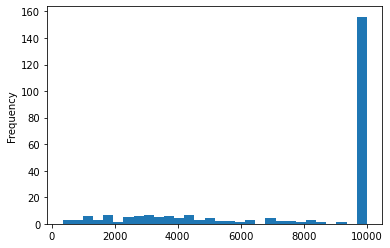

In [18]:
files['nchunks'].plot.hist(bins=30)

The average number of chunks is 7719 while the median is 10000. The minimum number of chunks is 343.

In [19]:
files['nchunks'].describe()

count      248.000000
mean      7719.826613
std       3258.018658
min        343.000000
25%       4488.000000
50%      10000.000000
75%      10000.000000
max      10000.000000
Name: nchunks, dtype: float64

The language with only 343 chunks is Lakku (лакку)

In [20]:
files[files['nchunks']==343]

,lang,fname,exfsize_MB,tf_totalsize_MB,tf_count,tf_avgsize_MB,fchunk_size_MB,nchunks
code,,,,,,,,
lbe,лакку,lbe.txt,0.33415,0.312386,1,0.312386,0,343


153 out of the 248 languages (so 62%) have a full 10000 chunks.

In [29]:
files['fchunk_size_MB'].sum()

1366

These files take up 1366 megabytes or 1.4 gigabytes on my computer - much smaller than the extracted or texts subdirectories!

### Example for a language
Here are the Turkish chunks

In [22]:
f = open(path+'chunked/tr.txt', 'r')
chtr = f.readlines()
f.close()

Each line is a chunk. Turkish has 10000 chunks:

In [23]:
len(chtr)

10000

Each line is 501 characters long (500 characters plus the newline character)

In [24]:
sum([len(l) for l in chtr])/len(chtr) # average line length

501.0

In [25]:
sum([len(l)==501 for l in chtr]) # this is the number of lines in the file that have exactly
# 501 characters. you see it's equal to the number of lines in the file

10000

These are the first five chunks:

In [26]:
chtr[:5] 

['zı ile karşılaşır Uyku kapsülleri içindeki insanlar etrafa saçılmıştır Bunlardan birisinin rüyalarına giren kadın Julia Rusakova olduğunu görerek şaşırır Bu arada Tetin gönderdiği İHAlar uyku kapsüllerine ateş açar ve Jackin canı pahasına koruduğu kadın dışındaki insanlar ölür Jack kadını Tete haber vermeden kendi küçük kulelerine götürür Vica kadını içeri sokmaz istemez ama Jacke karşı koyamaz Kadın sadece adının Julia olduğunu söyler mekiğin kara kutusunu dinlemeden bir şey söylemeyeceğini söy\n',
 'k dönüşlü konu içeriğini bulabilirsiniz Udo Steinkenin Heinrich Böll Willy Brandt ve HansDietrichGenscher ile sıkı dostluk bağları vardı Onun edebiyattaki katkılarından dolayı hatırasına Steinke Institut Bonn şehrinde kuruldu Enstitüt Udo Steinkenin arşivlerini bünyesinde bulundurmaktadır Ceritler Ceritler soy kökünün Oğuzların Bozok koluna bağlı Beğdili Begtili boyu olduğu bildirilir Yerleştikleri yer olarak da Dulkadiroğlu Beyliğinin sınırları içi olduğu değişik kaynaklarda belirtilme

---
# Explanation of data gathering pipeline
Now that the dataset is introduced, I'll explain how I gathered it. To assemble this full, final copy of the dataset, I ran my datagathering script on CRC over a period of days. The script is located in the datagather/crc directory of this repository.

I'm not sure how long the script itself would take on its own now because as I ran it, it would crash for various reasons (eg, writing large strings causing memory errors or networking set up wrong) or my session would expire, so I would need to fix the issue and start it running again where it left off. Sometimes I also had up to six copies of the script running at a time over the weekend when CRC had a lot of open resources, each collecting languages starting with a different letter of the alphabet.
## 1: Networking setup
CRC doesn't have enough storage space for the full dataset, so I needed to periodically send data somewhere else and delete all of one language's files from CRC before moving onto the next language. I would send files to an old laptop I have for storage (see second progress report for more details). 

Here is an outline of the networking aspects involved in my data gathering/cleaning:

Outside script

1. Get an internet address (or technically, publically expose port 22) for the storage laptop by running `./ngrok tcp 22` in shell and leaving it running
2. On my normal laptop, connect to Pitt's VPN (required to access CRC)
2. ssh to crc.h2p.pitt.edu to access CRC
3. Pass storage laptop's username, address and port to the script as command line arguments

Inside script

1. Prompt user for password, store it for future use in the runtime
2. Establish a test sftp connection with storage laptop to verify password (if fails, prompt user again)
3. After downloading a language's raw dump and extracting XML, send backup to device by opening a new sftp connection, transferring file, then closing connection (forms the extracted subdirectory)
4. Transfer another copy of the data after passing through the cleaning steps (forms the texts subdirectory)
5. Transfer another copy of the data after the chunking step (forms the chunked subdirectory)

What follows is an example that creates a very small exammple helloworld.txt file, then transfers it to another computer. I didn't bother with the VPN or ngrok for this simple example.

In [30]:
import paramiko
import getpass

In [31]:
# create the test file
fname = 'helloworld.txt'
f = open(fname, 'w')
f.writelines('hello world\n')
f.close()

In [32]:
username = 'snc'
port = 22
address = '10.0.0.25' # this is the computer's PRIVATE IP address: the address your internet
# router uses to distinguish this computer from any other device on your own network so 
# you don't recieve all the webpages requested by your brother and grandma or vice versa
# you can entering the IP address for your own computer here and use your laptop as the source 
# and the destination if you want to try it out. Then, it would be a bit like emailing or calling
# yourself in that the email is sent to the sender or the call is sent to the caller.

# to enable this sftp connection for a mac, go to System Preferences > Sharing > 
# Enable "Remote Login". There, it will display the IP address to use. Your source/local
# and destination/remote computers must be on the same wifi network unless you learn to use
# ngrok or something similar. Don't know how to do it on other operating systems 
# but there's probably tutorials on line if it isn't enabled by defailt.

In [33]:
pwd = getpass.getpass(prompt='sftp password: ') # password for your username 
# on destination/remote computer

sftp password: ········


In [34]:
# ESTABLISH CONNECTION
client = paramiko.client.SSHClient()
client.load_system_host_keys() # this loads any local ssh keys
client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
client.connect(address, port=port, username=username, password=pwd)
sftp = client.open_sftp() # type SFTPClient

# TRANSFER THE FILE
sftp.put('./'+fname, fname) #src, dest path/filename
print('transferred', fname)

# CLOSE THE CONNECTION
client.close()

	transferred helloworld.txt


If you run this yourself, look in your home (~) directory for the transferred file at the destination/remote computer.

## 2: Find the data files to download
The Wikipedia API offers a dictionary of all the languages of a Wikipedia edition that exists or used to exist. It provides both the language's abbreviation/code and name. So, my code iterates through this list:

In [35]:
langsdict = wikipedia.languages()
langsdict

{'aa': 'Qafár af',
 'ab': 'Аҧсшәа',
 'abs': 'bahasa ambon',
 'ace': 'Acèh',
 'ady': 'адыгабзэ',
 'ady-cyrl': 'адыгабзэ',
 'aeb': 'تونسي/Tûnsî',
 'aeb-arab': 'تونسي',
 'aeb-latn': 'Tûnsî',
 'af': 'Afrikaans',
 'ak': 'Akan',
 'aln': 'Gegë',
 'als': 'Alemannisch',
 'alt': 'алтай тил',
 'am': 'አማርኛ',
 'ami': 'Pangcah',
 'an': 'aragonés',
 'ang': 'Ænglisc',
 'anp': 'अङ्गिका',
 'ar': 'العربية',
 'arc': 'ܐܪܡܝܐ',
 'arn': 'mapudungun',
 'arq': 'جازايرية',
 'ary': 'الدارجة',
 'arz': 'مصرى',
 'as': 'অসমীয়া',
 'ase': 'American sign language',
 'ast': 'asturianu',
 'atj': 'Atikamekw',
 'av': 'авар',
 'avk': 'Kotava',
 'awa': 'अवधी',
 'ay': 'Aymar aru',
 'az': 'azərbaycanca',
 'azb': 'تۆرکجه',
 'ba': 'башҡортса',
 'ban': 'Basa Bali',
 'ban-bali': 'ᬩᬲᬩᬮᬶ',
 'bar': 'Boarisch',
 'bat-smg': 'žemaitėška',
 'bbc': 'Batak Toba',
 'bbc-latn': 'Batak Toba',
 'bcc': 'جهلسری بلوچی',
 'bcl': 'Bikol Central',
 'be': 'беларуская',
 'be-tarask': 'беларуская (тарашкевіца)\u200e',
 'be-x-old': 'беларуская (тарашкев

When I have the language's abbreviation `abv`, I can construct the download link for the wikipedia dump as: 

'*https://dumps.wikimedia.org/*' + `abv` + '*wiki/latest/*' + `abv` + '*wiki-latest-pages-articles.xml.bz2*'

Once I download it, I store it on my computer. Then, I check to see if the file is already present locally before re-downloading. This way I don't need to keep stressing Wikipedia's server each time I run my program. Some wikipedias are closed/no longer maintained and throw an error if I try to download, so I just skip those languages. Also, I deem languages as too small if their raw dump file size is less than 1MB, I'll discuss more why later.

## 3: Download raw wikipedia XML files
The script downloads these automatically, they come in a compressed .xml.bz format.

In [36]:
dumpspath = './datagather/dumps/' # where I'm storing the raw files
dumpsraw = dict()
for f in os.listdir(dumpspath):
    if f.startswith('.'): continue
    lang = f[:f.index('.')-4] # isolate just name of the language
    dumpsraw[lang] = [langsdict[lang], os.path.getsize(dumpspath + f)]

Dataframe of the languages I've gotten - 248 languages:

In [37]:
dumps = pd.DataFrame.from_dict(dumpsraw, columns=['name', 'fsize'], orient='index')
print(dumps.shape)
dumps.head()

(248, 2)


,name,fsize
ht,Kreyòl ayisyen,13973117
li,Limburgs,14315808
ig,Igbo,2109360
tet,tetun,1222946
wuu,吴语,14397542


This is the number of bytes for these raw dump files alone, which is about 76 gigabytes:

In [38]:
dumps['fsize'].sum() 

76499174416

These are the languages I skipped for either of the reasons I mentioned:

In [39]:
excluded = [langsdict[l] for l in langsdict.keys() if l not in dumps.index]
print(len(excluded), 'languages excluded:\n', ', '.join(excluded))

209 languages excluded:
 Qafár af, bahasa ambon, адыгабзэ, адыгабзэ, تونسي/Tûnsî, تونسي, Tûnsî, Akan, Gegë, алтай тил, Pangcah, अङ्गिका, ܐܪܡܝܐ, mapudungun, جازايرية, American sign language, Atikamekw, ᬩᬲᬩᬮᬶ, žemaitėška, Batak Toba, Batak Toba, جهلسری بلوچی, беларуская (тарашкевіца)‎, беларуская (тарашкевіца)‎, روچ کپتین بلوچی, भोजपुरी, Bislama, bamanankan, بختیاری, Bráhuí, Batak Mandailing, Iriga Bicolano, Chavacano de Zamboanga, Chamoru, Choctaw, ᏣᎳᎩ, Tsetsêhestâhese, Capiceño, Nēhiyawēwin / ᓀᐦᐃᔭᐍᐏᐣ, къырымтатарджа (Кирилл)‎, qırımtatarca (Latin)‎, словѣньскъ / ⰔⰎⰑⰂⰡⰐⰠⰔⰍⰟ, Österreichisches Deutsch, Schweizer Hochdeutsch, Deutsch (Sie-Form)‎, Thuɔŋjäŋ, Dusun Bundu-liwan, ཇོང་ཁ, eʋegbe, Emiliàn, Canadian English, British English, español de América Latina, español (formal)‎, Fulfulde, meänkieli, võro, Na Vosa Vakaviti, français cadien, 赣语（简体）‎, 贛語（繁體）‎, kriyòl gwiyannen, गोंयची कोंकणी, Gõychi Konknni, 𐌲𐌿𐍄𐌹𐍃𐌺, Ἀρχαία ἑλληνικὴ, Alemannisch, wayuunaiki, Hawaiʻi, Fiji Hindi, Ilonggo, Hiri M

But these are the ones I was able to get:

In [40]:
print(dumps.shape[0], 'languages included:\n', ', '.join(dumps['name']))

248 languages included:
 Kreyòl ayisyen, Limburgs, Igbo, tetun, 吴语, коми, الدارجة, latviešu, la .lojban., भोजपुरी, мокшень, Zeêuws, oʻzbekcha/ўзбекча, تۆرکجه, සිංහල, norsk nynorsk, português, Bahasa Melayu, अवधी, 中文, тыва дыл, svenska, башҡортса, മലയാളം, Tagalog, arpetan, slovenščina, Afrikaans, Jawa, Yorùbá, Mirandés, ગુજરાતી, Frysk, Māori, Xitsonga, sicilianu, italiano, Aymar aru, Gagauz, ꯃꯤꯇꯩ ꯂꯣꯟ, davvisámegiella, føroyskt, తెలుగు, brezhoneg, català, Адыгэбзэ, dansk, 贛語, Pälzisch, Nāhuatl, Novial, qırımtatarca, Simple English, dolnoserbski, ߒߞߏ, Oromoo, অসমীয়া, English, lumbaart, বাংলা, پنجابی, hrvatski, Nouormand, ລາວ, ଓଡ଼ିଆ, русский, 한국어, interlingua, Papiamentu, къарачай-малкъар, Кыргызча, Kotava, български, azərbaycanca, vepsän kel’, Alemannisch, Gaelg, Plattdüütsch, livvinkarjala, Soomaaliga, Piemontèis, Sunda, Ænglisc, galego, Hausa, Mìng-dĕ̤ng-ngṳ̄, کوردی, ייִדיש, emiliàn e rumagnòl, ਪੰਜਾਬੀ, авар, walon, română, Picard, kurdî, گیلکی, مصرى, suomi, မြန်မာဘာသာ, kaszëbsczi, Baha

Largest wikipedias by raw dump file size:

In [41]:
dumps.sort_values('fsize', ascending=False).head(10) # largest wikis included

,name,fsize
en,English,18267134864
de,Deutsch,5877797639
fr,français,4972442407
ru,русский,4224935955
ja,日本語,3309015603
es,español,3144443923
it,italiano,3129866871
zh,中文,2122775813
pl,polski,2024669975
pt,português,1831289660


English alone is about 18 GB! The distant second is German at about 6 GB.

Smallest file sizes that I included (since cutoff was 1MB):

In [42]:
dumps.sort_values('fsize').head(10) # smallest wikis included

,name,fsize
nqo,ߒߞߏ,1049963
jbo,la .lojban.,1074932
pdc,Deitsch,1085523
nov,Novial,1111229
mdf,мокшень,1119182
smn,anarâškielâ,1149766
lbe,лакку,1188547
tet,tetun,1222946
kbp,Kabɩyɛ,1316060
tpi,Tok Pisin,1371967


Plot of the filesizes for the languages I included. You can see most are quite small, while a few are very big.

<AxesSubplot:ylabel='Frequency'>

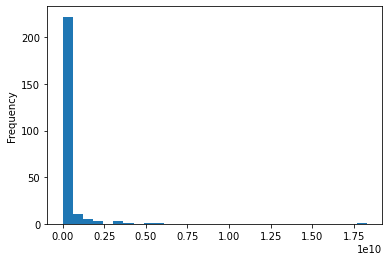

In [43]:
dumps['fsize'].plot.hist(bins=30) # many small wikis, just a few big wikis

Here is an example of Qaraqalpaqsha's raw dump file, if I manually decompress it (I don't store these anywhere, it's all handled by the extractor tool I use):

In [44]:
f = open('./data_samples/kaa-raw.xml', 'r')
exdump = f.readlines()
f.close()
exdump[:20] # start of file

['<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="kaa">\n',
 '  <siteinfo>\n',
 '    <sitename>Wikipedia</sitename>\n',
 '    <dbname>kaawiki</dbname>\n',
 '    <base>https://kaa.wikipedia.org/wiki/Bas_bet</base>\n',
 '    <generator>MediaWiki 1.36.0-wmf.31</generator>\n',
 '    <case>first-letter</case>\n',
 '    <namespaces>\n',
 '      <namespace key="-2" case="first-letter">Media</namespace>\n',
 '      <namespace key="-1" case="first-letter">Arnawlı</namespace>\n',
 '      <namespace key="0" case="first-letter" />\n',
 '      <namespace key="1" case="first-letter">Sa\'wbet</namespace>\n',
 '      <namespace key="2" case="first-letter">Paydalanıwshı</namespace>\n',
 '      <namespace key="3" case="first-letter">Paydalanıwshı sa\'wbeti</namespace>\n',
 '      <namespace key="4" case="fi

In [45]:
exdump[3745:3765] # random middle part showing part of an article 

['      <sha1>j4b51cvuaoqrzh27274l7fzp3q29453</sha1>\n',
 '    </revision>\n',
 '  </page>\n',
 '  <page>\n',
 "    <title>A'jiniyaz</title>\n",
 '    <ns>0</ns>\n',
 '    <id>152</id>\n',
 '    <revision>\n',
 '      <id>43321</id>\n',
 '      <parentid>30626</parentid>\n',
 '      <timestamp>2020-05-01T08:16:04Z</timestamp>\n',
 '      <contributor>\n',
 '        <ip>185.163.26.25</ip>\n',
 '      </contributor>\n',
 '      <model>wikitext</model>\n',
 '      <format>text/x-wiki</format>\n',
 '      <text bytes="7440" xml:space="preserve">\'\'\'A\'jiniyaz Qosıbay ulı\'\'\' (a\'debiy laqabı \'\'Ziywar\'\') - XIX a\'sirdegi qaraqalpaq klassik a\'debiyatının\' en\' o\'rnekli wa\'killerinin\' biri. Ol do\'retiwshiliginde o\'zine ta\'n o\'zgeshelikke iye, og\'ada talantlı, oqımıslı, medreseni ayrıqsha tamamlag\'an aqun, ulama, ko\'rkem so\'z sheberi sıpatında basqalardan ayrılıp turatug\'ın uqıplılıq penen o\'z da\'wirinin\' progressiv idealların ju\'zege shıg\'ardı, anıq turmıs haqıyqatl

One of the languages that ultimately gets excluded is Qafár af. Here I'll read in its expanded dump file:

In [46]:
f = open('./data_samples/aa-raw.xml')
aaraw = f.readlines()
f.close()

In [47]:
aaraw[:20]

['<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="aa">\n',
 '  <siteinfo>\n',
 '    <sitename>Wikipedia</sitename>\n',
 '    <dbname>aawiki</dbname>\n',
 '    <base>https://aa.wikipedia.org/wiki/Main_Page</base>\n',
 '    <generator>MediaWiki 1.36.0-wmf.32</generator>\n',
 '    <case>first-letter</case>\n',
 '    <namespaces>\n',
 '      <namespace key="-2" case="first-letter">Media</namespace>\n',
 '      <namespace key="-1" case="first-letter">Special</namespace>\n',
 '      <namespace key="0" case="first-letter" />\n',
 '      <namespace key="1" case="first-letter">Talk</namespace>\n',
 '      <namespace key="2" case="first-letter">User</namespace>\n',
 '      <namespace key="3" case="first-letter">User talk</namespace>\n',
 '      <namespace key="4" case="first-letter">Wikipedia</names

In [48]:
len(aaraw)

5526

At first glance, this language's XML file has 5526 lines, which sounds like enough to at least get a good sampling of what the language looks like. But then I stripped all the XML and extra Wikipedia information off.

## 4: Remove the XML and wikipedia formatting
Wikipedia formatting is stuff like the particular templates used in the articles, the random stuff you see at the very start of the above raw XML file, etc.

In [49]:
f = open('./data_samples/aa-extracted.txt')
aa = f.readlines()
f.close()

Here is Qafár af (the example excluded language)'s *entire* file without the XML and extra Wikipedia formatting:

In [50]:
aa

['{"id": "1426", "revid": "2266", "url": "https://aa.wikipedia.org/wiki?curid=1426", "title": "Main page", "text": ""}\n',
 '{"id": "2105", "revid": "361", "url": "https://aa.wikipedia.org/wiki?curid=2105", "title": "Wikipedia", "text": "Wikipedia bödero kœáth amliethog e rhyδ gē gell tō un gelœga. Denn grëað zero œáthws ar ðechre di zera gentannwm hon."}\n']

As you can see, the output of the tool I used is one json object per page/article. From 5526 lines, Qafár af is left with just two pages, one of which has no text at all. The other page is just a sentence long; it seems to be a message notifying users that this wikipedia is closed and not maintained. This is why I excluded languages whose raw dump files are smaller than 1MB.

Returning to Qaraqalpaqsha, which I showed the raw dump for earlier, here is its Wikipedia with the XML and Wikipedia formatting removed:

In [51]:
f = open('./data_samples/kaa-extracted.txt', 'r')
kaa = f.readlines()
f.close()

In [52]:
kaa[:3] # first 3 json objects

['{"id": "16", "revid": "19", "url": "https://kaa.wikipedia.org/wiki?curid=16", "title": "Main Page", "text": ""}\n',
 '{"id": "140", "revid": "6", "url": "https://kaa.wikipedia.org/wiki?curid=140", "title": "Bas bet/Interwikis", "text": "&lt;includeonly&gt; &lt;/includeonly&gt;"}\n',
 '{"id": "148", "revid": "17", "url": "https://kaa.wikipedia.org/wiki?curid=148", "title": "A\'bdiraman O\'tepov", "text": "A\'bdiraman O\'tepov (1905-1934) - qaraqalpaq dramaturgiyasının\' tiykarın salıwshılardın\' biri. Ol talantlı dramaturg, rejissyor, aktyor, muzıkant, ko\'rnekli teatr iskeri sıpatında qaraqalpaq xalqının\' tariyxında belgili iz qaldırdı. \\nA\'.O\'tepov 1905 jılı Qon\'ıratta mayda sawdager semyasında tuwıldı. 1906 jılı a\'kesi semyası menen Aral ten\'izinin\' qubla-shıg\'ıs jag\'asına jaqın Qosjap degen jerge ko\'ship keledi ha\'m balıq o\'ndirisi ka\'sibi menen shug\'ıllana baslaydı. Bul O\'tepovtın\' semyasının\' ruslar menen jaqınlasıwına mu\'mkinshilik tuwdırdı.\\n1910 jılı ol Ni

The encoding is causing some weird display issues for some characters here, it's strange because it shows up fine in my text editor and in zsh with the `head` command. Either way, it gets corrected once it travels through the rest of my current data correction pipeline and the final file for this language which I'll show later displays fine.

The tool I'm using to go from raw dump to "clean" json items is called WikiExtractor. The current version on GitHub is not stable, but it's here: https://github.com/attardi/wikiextractor

I forked it and made a stable version here: https://github.com/soCromp/wikiextractor

I needed to use specifically this tool for another project I'm doing in another class and spent a lot of time fixing it and figuring out how to run it. It's designed specifically for processing Wikipedia data en masse and already "knows" Wikipedia formatting and how to find certain article attributes. As a result, I decided to just use it again here rather than learn how to use totally another thing like Beautiful Soup - I've used their Java library a couple years ago (jsoup) and remembered taking a while to get data cleaned like I wanted. 

The tool runs pretty quick - Afrikaans takes 1-2 minutes and English maybe 5. I also pass the text through some shell regex like `sed` at this point for a little extra cleaning. Shell regex seems to run faster than Python regex?

## 5: Get the article text
The next step in the pipeline is doing some encoding correction after the XML and Wikipedia formatting is extracted. Then, I grab just article text from the json objects.

In [53]:
f = open('./data_samples/af-articles.txt')
aftexts = f.readlines()
f.close()

In [54]:
print(''.join(aftexts[:4]))

 Afrika
Afrika is die wêreld se tweede grootste kontinent (na Asië) in sowel oppervlakte as bevolking. Saam met die eilande beslaan dit ongeveer 30 221 532 km² wat 20,3% van die totale landoppervlakte van die aarde is en dit word bewoon deur meer as 1 miljard mense – ongeveer 'n sewende van die wêreldbevolking.
Tale.
Die meeste amptelike tale van Afrika is Indo-Europese tale soos Frans, Engels, Portugees, Spaans en Afrikaans.



As you can see, it still has line breaks, punctuation, numbers, etc.

After this step, I was planning to tokenize. I added this in and started to run the script on all the data, but disliked the results I was getting. I don't know what tool I could use to tokenize different languages since there are so many different rules and probably a lot of things I don't know about how to tokenize the languages I don't speak. So, I just took the tokenizing step out at least for now.
## 6: Cleaning to remove punctuation, extra spaces
Next, I just pass the text through a filter to remove all puntuation characters and replace sequences of multiple spaces in a row with just one space. I use a special unicode library function, unicodedata.category() to detect any unicode puntuation character in order to catch even puntuation like the Japanese period "。"

In [55]:
f = open('./data_samples/af-text.txt')
afclean = f.readlines()
f.close()

In [56]:
afclean[0][:402]

' Afrika Afrika is die wêreld se tweede grootste kontinent na Asië in sowel oppervlakte as bevolking Saam met die eilande beslaan dit ongeveer \xa0 \xa0 \xa0km wat van die totale landoppervlakte van die aarde is en dit word bewoon deur meer as miljard mense ongeveer n sewende van die wêreldbevolking Tale Die meeste amptelike tale van Afrika is IndoEuropese tale soos Frans Engels Portugees Spaans en Afrikaans '

Again, there is some strange encoding issue when I display it in Jupyter. You can see it in the spaces between where the numbers were. It doesn't occur when I display it in Atom, Sublime or TextEdit.

## 7: Chunking and shuffling
Originally I had the idea to make each line a sentence or a certain number of words. Then I realized not all languages separate words or sentences the same way, and decided the most language-neutral way to do this would be to simply make each line 500 characters long. I refer to each line as a chunk, and simply divide the long block of text every 500 characters. I'm sure there are better ways to handle this, but I chose this simple way for now at least. Then, if there are more than 100000 chunks, I randomly sample 100000 chunks to prevent any larger languages from being overrepresented in my data. This number is somewhat arbitrary so I might revisit later. Lastly, I shuffle the chunks.

In [57]:
f = open('./data_samples/af-chunks.txt', encoding='utf-8')
af = f.readlines()
f.close()

First five Afrikaans chunks:

In [58]:
af[:5]

['de gereïnkarneer word Elke hergeboorte vind plaas op een van vyf vlakke volgens TheravadaBoeddhiste of ses volgens ander skole Volgens OosAsiatiese en Tibettaanse Boeddhisme is daar n tussenvlak Tibettaans bardo tussen een lewe en die volgende een Die ortodokse Theravadatradisie verwerp dit tog is daar dele in die Samyuttanikaya van die Palikanon wat blykbaar die idee steun dat die Boeddha vertel het van so n tussenvlak Lyding oorsake en oplossings Die Vier Edel Waarhede Die leringe oor die Vier\n',
 'de wat erosie bevorder Die klimaat het ook sy invloed laat geld Die afgelope miljoen jaar het die klimaatstoestande drie keer gewissel van vogtig en nat tot droog Só het die eens uit gebreide tropiese reënwoud al hoe kleiner geword Aan die ander kant het die veranderinge in die klimaat die dier en plantsoorte gedwing om hulle by die nuwe omstandighede aan te pas Só het n groot verskeidenheid fauna en flora ontwikkel Dat Afrika steeds die woonplek van die groot soogdiere is is te danke a

In [59]:
f = open('./data_samples/en-chunks.txt', encoding='utf-8')
en = f.readlines()
f.close()

First 5 English chunks:

In [60]:
en[:5]

['because snow does not cover the trees as readily Deciduous trees have an albedo value of about to whereas coniferous trees have a value of about to Variation in summer albedo across both forest types is correlated with maximum rates of photosynthesis because plants with high growth capacity display a greater fraction of their foliage for direct interception of incoming radiation in the upper canopy The result is that wavelengths of light not used in photosynthesis are more likely to be reflected\n',
 'ous diseases solvents PCBs phthalates and phenols used in plastic products pesticides brominated flame retardants alcohol smoking illicit drugs vaccines and prenatal stress Some such as the MMR vaccine have been completely disproven Parents may first become aware of autistic symptoms in their child around the time of a routine vaccination This has led to unsupported theories blaming vaccine overload a vaccine preservative or the MMR vaccine for causing autism The latter theory was suppo

Some of the encoding issues from files I showed you mid-pipeline do not seem present in these written out files.

In [61]:
f = open('./data_samples/kaa-chunks.txt', encoding='utf-8')
kaa = f.readlines()
f.close()

The weird encoding errors are now gone for Qaraqalpaqsha. Here are its first 5 chunks:

In [62]:
kaa[:5]

[' suwretlengen Kartada korsetiwinshe Kaspiyge Zarafshan ham Amiwdarya Okus quyıp turgan Amiwdarya jıl burın Tyanshan tawınan baslap Fergana oypatlıgınan agıp otken Sonın menen birge sayaxatshı Marko Polo ogan İon dep at bergen al Sırdaryanı Yaskart dep atagan Aral tenizi jagasınan Sarıqamıs Akespe den m terenlikten arxeologiyalıq qazılmalar boyınsha tasqa aylangan kit omırtqasının ham qızıl balıqtın suyekleri tabıldı ol oligatsena dawirinde jasaganı anıqlandı Usı orınga jaqın yamasa Nokistin qubl\n',
 'r legendalar qaraqalpaq korkem awızeki doretpelerinin belgili bir janrı bolıp doreliwi jagınan juda ayyemgi zamanlarga barıp jetedi Olar ozinin mazmunı turtusi boyınsha basqa xalıq awızeki doretpelerinin janrlarınan ayırılıp turadı Anızlar kopshilik jagdaylarda bolmagan narselerdi bolganday etip suwretleytugın awızeki prozalıq doretpeler Olardı burın apsanalar ham rawiyatlar menen aralastırıp bir janr retinde uyrenildi Anızlar qaraqalpaq ertekleri menen birge XIXasirdin jıllarında XX as

In [63]:
f = open('./data_samples/ml-chunks.txt')
ml = f.readlines()
f.close()

There are still some weird encoding issues with Jupyter specifically. In Malayalam, Jupyter can't display this right: ണ്‌ 

Even pasting it into this markup cell, it's showing me a red dot next to this character when I'm in edit mode, I guess to say it doesn't want to show the diacritic mark. And in the following code printout, it shows the character as \u200c instead.

In [64]:
ml[:5]

['ഭിപ്രായത്തിൽ എഡി മുതലാണ്\u200c ഓണം ആഘോഷിച്ചു തുടങ്ങിയത്\u200c മഹാബലിയുടെ ഓർമ്മക്കായി ഭാസ്കര രവിവർമ്മയാണിത്\u200c ആരംഭിച്ചതെന്നും ലോഗൻ അഭിപ്രായപ്പെടുന്നു കേരള ചരിത്ര കർത്താവ്\u200c കൃഷ്ണപിഷാരടി എഡി നും നും ഇടയിൽ ഓണം ആഘോഷിക്കാൻ തുടങ്ങിയതായി പറയുന്നു പതിനൊന്നാം നൂറ്റാണ്ടിൽ കേരളം സന്ദർശിച്ച അറബിസഞ്ചാരി അൽബി റൂണിയും ൽ വന്ന ഈജിപ്ഷ്യൻ സഞ്ചാരി അൽ ഇദ്രീസിയും ൽ ഫ്രഞ്ച്\u200c സഞ്ചാരി ബഞ്ചമിനുമെല്ലാം മലയാളിയുടെ ഓണത്തെക്കുറിച്ചും ആഘോഷങ്ങളെക്കുറിച്ചും കളികളെക്കുറിച്ചും വിവരിക്കുന്നുണ്ട്\u200c ഓണാഘോഷത്തെപ്പറ്റിയുള്ള ശിലാലിഖിതങ്ങളും കണ്ടുകി\n',
 ' എൻ ഡി പി യോഗമായി മാറി ഈ സംഘടനയെ മാതൃകാപരമായ ഒരു ജാതിമതാതീത സംഘടനയായി വളർത്തിക്കൊണ്ടുവരികയും സമൂഹത്തെ സർവതോമുഖമായ പുരോഗതിയിലേക്കു നയിക്കുകയും ചെയ്യുകയായിരുന്നു ഗുരുവിന്റെ ലക്ഷ്യം ആദ്യത്തെ ഏതാനും വർഷങ്ങളിൽ സാമാന്യം ഭേദപ്പെട്ട രീതിയിൽ കാര്യങ്ങൾ മുന്നോട്ടുപോയി എന്നാൽ യോഗം നേതാക്കളിൽ പലരും അവസരോചിതമായി ഉയർന്നുചിന്തിക്കുകയും പ്രവർത്തിക്കുകയും ചെയ്യാത്തതുമൂലം യോഗവും ഗുരുവും തമ്മിലുള്ള ബന്ധത്തിൽ ക്രമേണ വിടവ് അനുഭവപ്പെട്ടു തന്റെ ദർശനത്തിന്റെ കാതലായ ഏകജാതിസന്ദേശം താ

I'm not sure how much I can do about that issue; I know the correct "information" for that character is in there since these files are displaying correctly on my computer. I've tried reading the file in with different encoding schemes or doing the `str.encode('utf-8').decode('raw_unicode_escape')` trick.

As much as I want to fix it, it potentially is a deeply embedded issue in my browser or Jupyter or even my operating system. Knowing there's plenty of other stuff to do with the project, it's probably important that I prioritize at this point.

# To do (for data preparation)
- Anonymize writing system using method described in first progress report (see there for details)
- Create corpus that has all languages mixed and shuffled together, with each chunk labeled for its language
- Feature extraction 
- Split into train/dev/test sets, ensuring equal representation of languages